<a href="https://colab.research.google.com/github/prabhjeet2570-spec/finance-and-economics-time-series-analysis/blob/main/ds_bootcamp_project_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finance & Economics Time-Series Analysis**

## **Section 1: Setup and data loading**

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# Time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Deep Learning
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except:
    KERAS_AVAILABLE = False
    print("⚠️ TensorFlow not available - LSTM models will be skipped")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

print("📦 All libraries imported successfully!")

📦 All libraries imported successfully!


In [74]:
# Load Data from Kaggle
import kagglehub
path = kagglehub.dataset_download("khushikyad001/finance-and-economics-dataset-2000-present")
print(f"Dataset path: {path}")

# Read the CSV file
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"Available files: {csv_files}")

df = pd.read_csv(os.path.join(path, csv_files[0]))
print(f"\n✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(df.head())

Using Colab cache for faster access to the 'finance-and-economics-dataset-2000-present' dataset.
Dataset path: /kaggle/input/finance-and-economics-dataset-2000-present
Available files: ['finance_economics_dataset.csv']

✅ Dataset loaded: 3000 rows, 24 columns
         Date Stock Index  Open Price  Close Price  Daily High  Daily Low  \
0  2000-01-01   Dow Jones     2128.75      2138.48     2143.70    2100.55   
1  2000-01-02     S&P 500     2046.82      2036.18     2082.83    2009.53   
2  2000-01-03   Dow Jones     1987.92      1985.26     2022.28    1978.37   
3  2000-01-04   Dow Jones     4625.02      4660.47     4665.26    4595.46   
4  2000-01-05     S&P 500     1998.18      1982.18     2044.31    1966.44   

   Trading Volume  GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
0         2670411           -0.37                6.06                   6.10   
1       690220415            3.19                4.95                   6.62   
2       315284661            5.54    

## **Section 2: Data cleaning & preprocessing**

In [75]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Check missing values
print("\n📊 Missing Values Analysis:")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_summary[missing_summary['Missing_Count'] > 0])

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Basic statistics
print("\n📈 Dataset Overview:")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of Stock Indices: {df['Stock Index'].nunique()}")
print(f"Stock Indices: {df['Stock Index'].unique()}")

# Separate data by stock index and focus on S&P 500
sp500_df = df[df['Stock Index'] == 'S&P 500'].copy()
nasdaq_df = df[df['Stock Index'] == 'NASDAQ'].copy()
dowjones_df = df[df['Stock Index'] == 'Dow Jones'].copy()

print(f"\n✅ S&P 500: {len(sp500_df)} records")
print(f"✅ NASDAQ: {len(nasdaq_df)} records")
print(f"✅ Dow Jones: {len(dowjones_df)} records")

# Focus on S&P 500 for modeling
sp500_df = sp500_df.reset_index(drop=True)

# Handle missing values using forward fill (appropriate for time series)
# Economic indicators change slowly, so forward fill is reasonable
econ_cols = ['GDP Growth (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)',
             'Interest Rate (%)', 'Consumer Confidence Index', 'Government Debt (Billion USD)']

for col in econ_cols:
    sp500_df[col] = sp500_df[col].fillna(method='ffill').fillna(method='bfill')

# Price and volume data
price_cols = ['Open Price', 'Close Price', 'Daily High', 'Daily Low', 'Trading Volume']
for col in price_cols:
    sp500_df[col] = sp500_df[col].fillna(method='ffill').fillna(method='bfill')

print(f"\n✅ Missing values handled. Working dataset shape: {sp500_df.shape}")


📊 Missing Values Analysis:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []

📈 Dataset Overview:
Date Range: 2000-01-01 00:00:00 to 2008-03-18 00:00:00
Number of Stock Indices: 3
Stock Indices: ['Dow Jones' 'S&P 500' 'NASDAQ']

✅ S&P 500: 1036 records
✅ NASDAQ: 1007 records
✅ Dow Jones: 957 records

✅ Missing values handled. Working dataset shape: (1036, 24)


## **Section 3: Exploratory data analysis (EDA)**

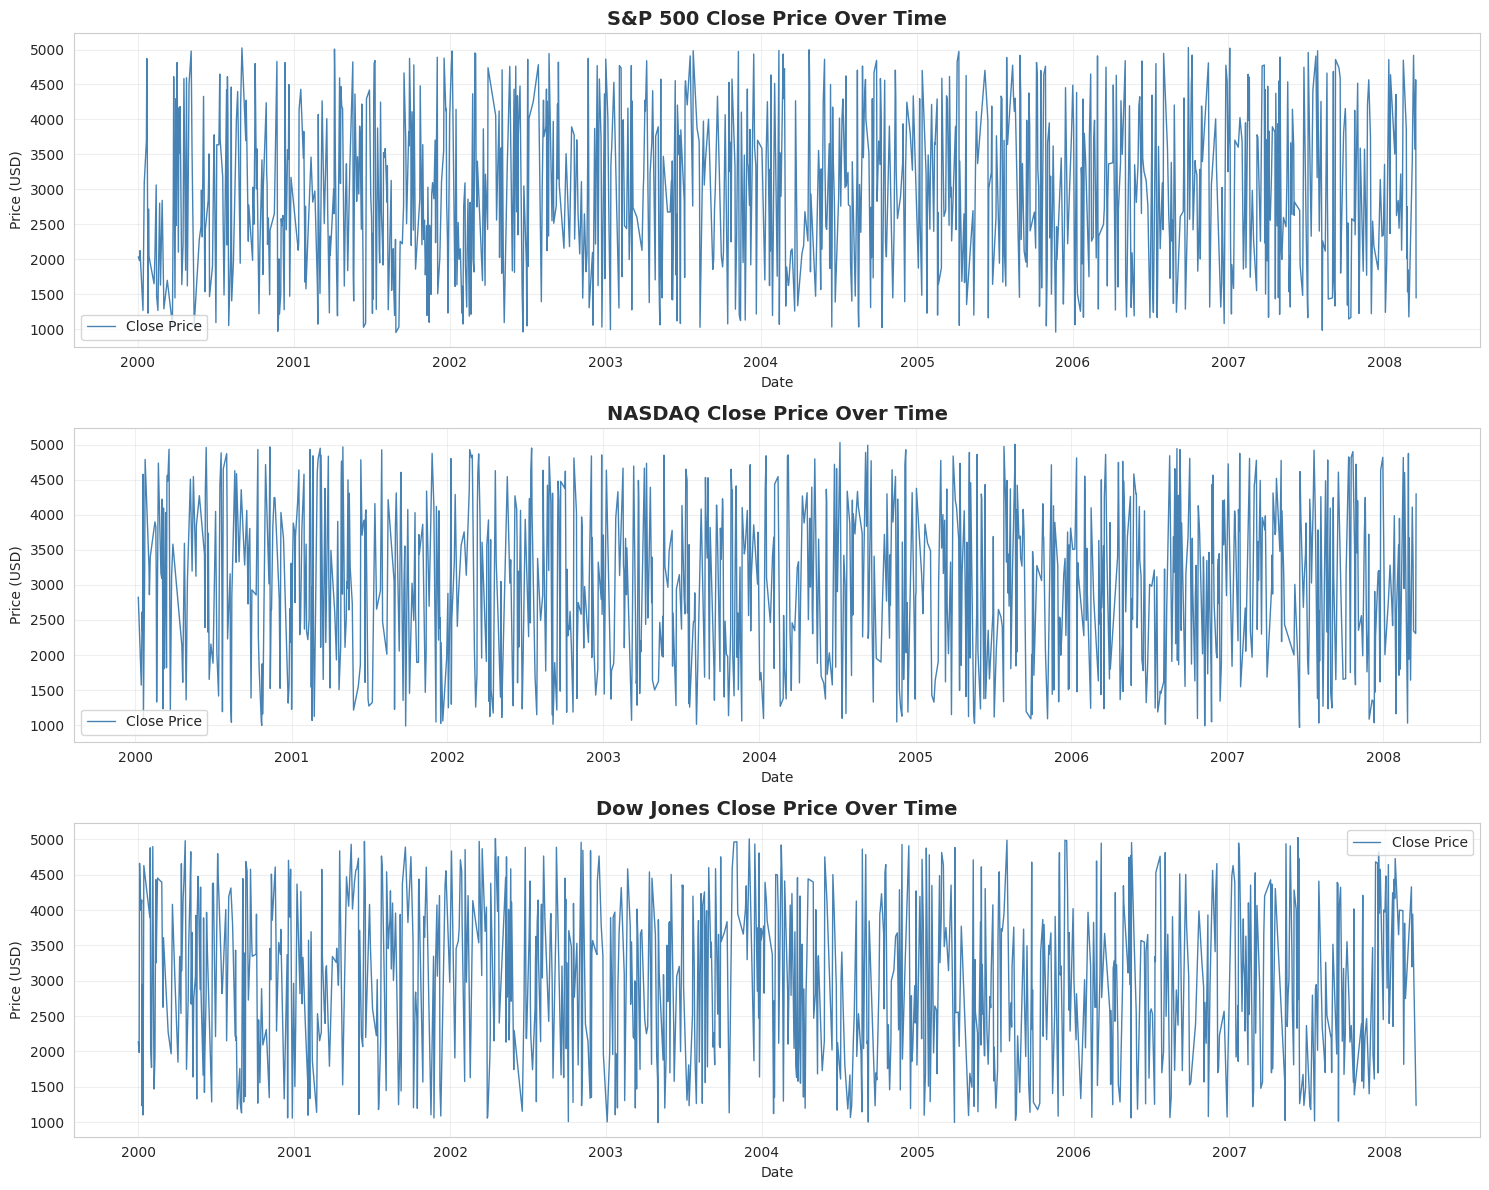

In [76]:
# Visualization 1: Stock Price Trends for all indices
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, (name, data) in enumerate([('S&P 500', sp500_df), ('NASDAQ', nasdaq_df), ('Dow Jones', dowjones_df)]):
    axes[idx].plot(data['Date'], data['Close Price'], label='Close Price', linewidth=1, color='steelblue')
    axes[idx].set_title(f'{name} Close Price Over Time', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price (USD)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stock_prices_trend.png', dpi=300, bbox_inches='tight')
plt.show()

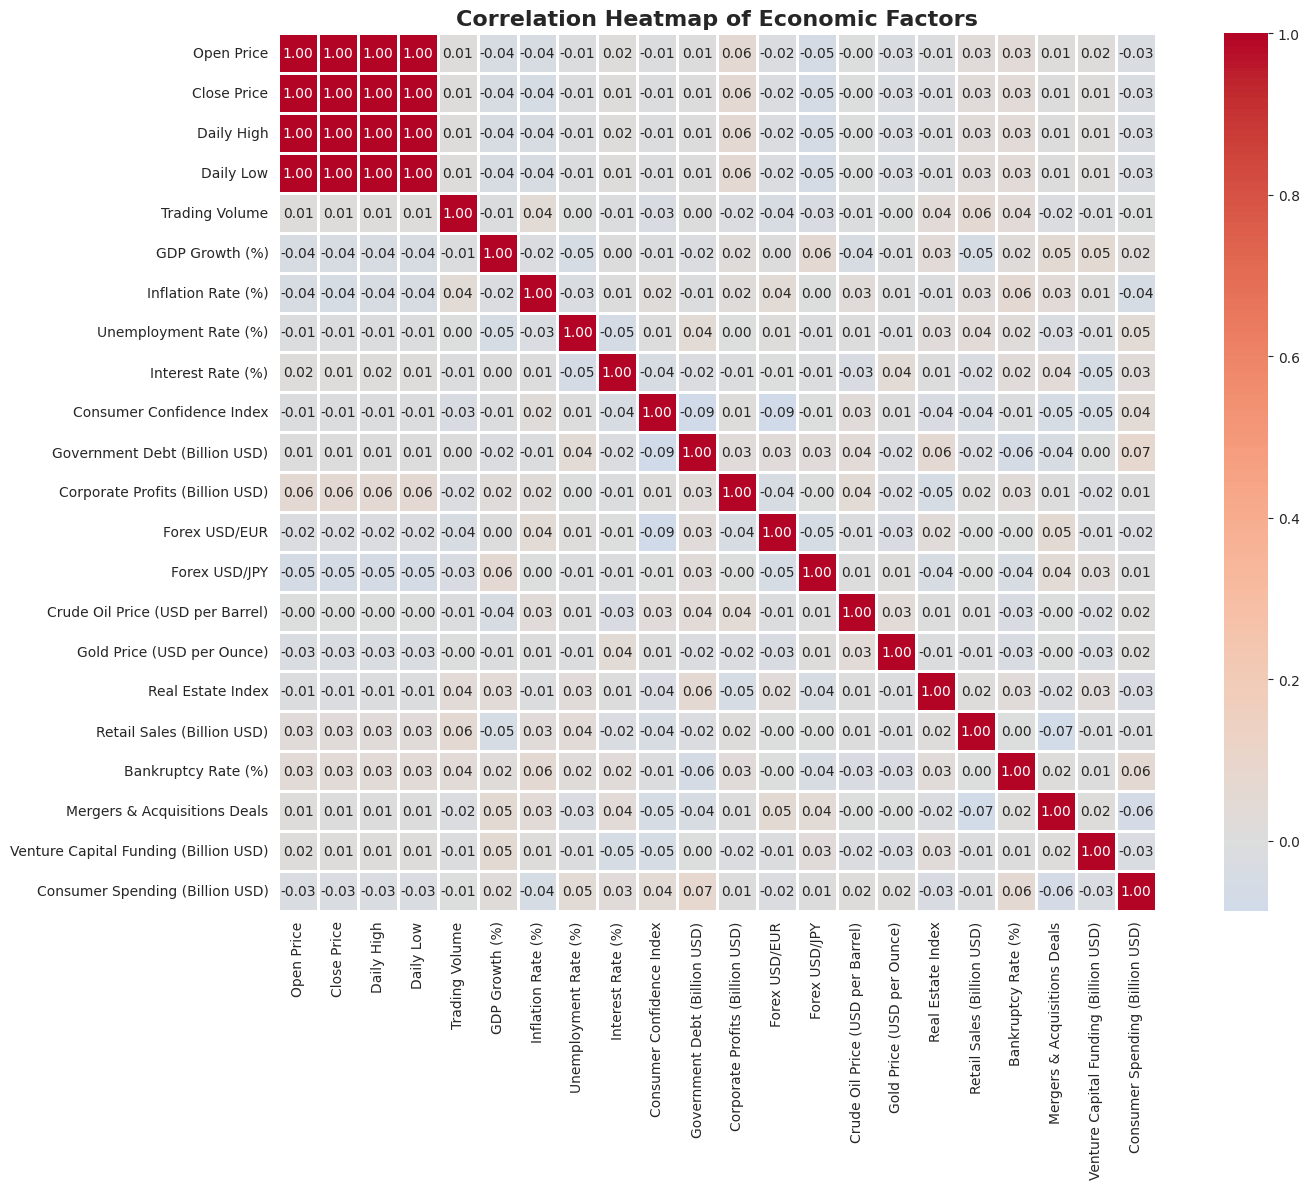

In [77]:
# Visualization 2: Correlation Heatmap
numeric_df = sp500_df.select_dtypes(include=[np.number])
plt.figure(figsize=(16, 12))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap of Economic Factors', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

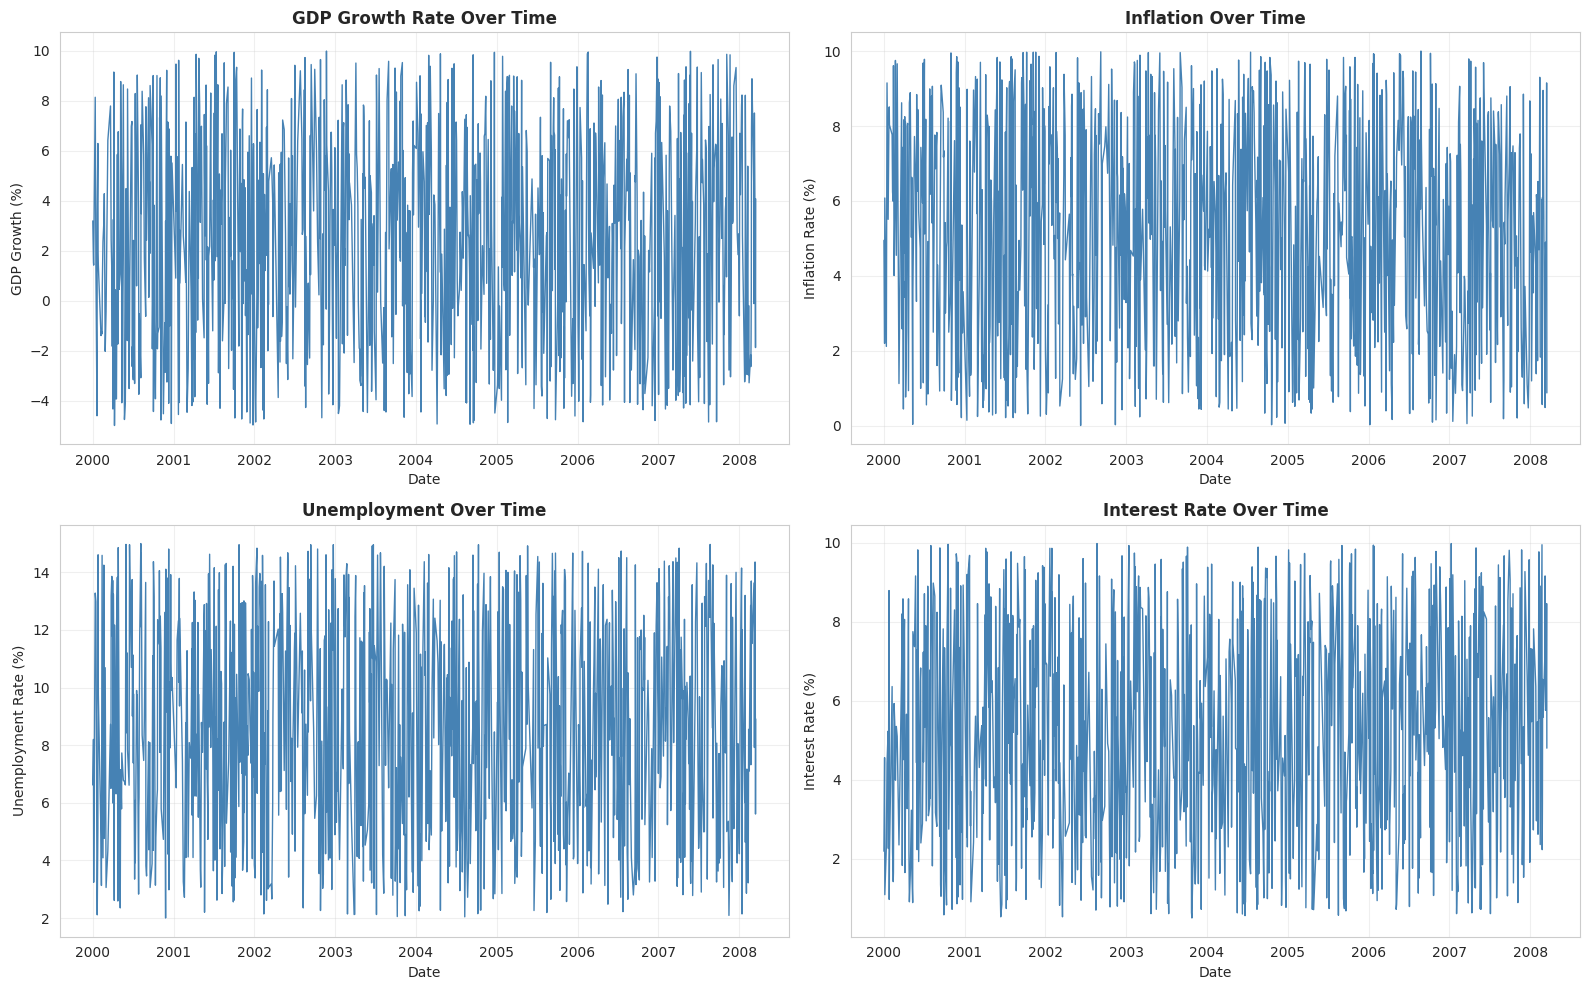

In [78]:
# Visualization 3: Key Economic Indicators
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

indicators = [
    ('GDP Growth (%)', 'GDP Growth Rate'),
    ('Inflation Rate (%)', 'Inflation'),
    ('Unemployment Rate (%)', 'Unemployment'),
    ('Interest Rate (%)', 'Interest Rate')
]

for idx, (col, title) in enumerate(indicators):
    ax = axes[idx // 2, idx % 2]
    ax.plot(sp500_df['Date'], sp500_df[col], color='steelblue', linewidth=1)
    ax.set_title(f'{title} Over Time', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('economic_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

## **Section 4: Feature engineering**

In [79]:
def create_features(df):
    """
    Create time series features for forecasting
    KEY FIX: Use PREVIOUS day's data to avoid data leakage!
    """
    df = df.copy()

    # 1. LAGGED PRICE FEATURES
    # Use yesterday's prices as features - NO DATA LEAKAGE
    df['Prev_Close'] = df['Close Price'].shift(1)
    df['Prev_Open'] = df['Open Price'].shift(1)
    df['Prev_High'] = df['Daily High'].shift(1)
    df['Prev_Low'] = df['Daily Low'].shift(1)
    df['Prev_Volume'] = df['Trading Volume'].shift(1)

    # 2. RETURNS (Daily price changes)
    df['Return_1d'] = df['Close Price'].pct_change(1)
    df['Return_5d'] = df['Close Price'].pct_change(5)
    df['Return_20d'] = df['Close Price'].pct_change(20)

    # 3. MOVING AVERAGES
    for window in [5, 10, 20, 50]:
        df[f'MA_{window}'] = df['Close Price'].rolling(window=window).mean()
        # Ratio of current price to MA (momentum indicator)
        df[f'MA_{window}_ratio'] = df['Close Price'] / df[f'MA_{window}']

    # 4. VOLATILITY INDICATORS
    df['Volatility_5'] = df['Return_1d'].rolling(window=5).std()
    df['Volatility_20'] = df['Return_1d'].rolling(window=20).std()

    # Price range (High - Low)
    df['Daily_Range'] = df['Daily High'] - df['Daily Low']
    df['Price_Range_Ratio'] = df['Daily_Range'] / df['Close Price']

    # 5. VOLUME INDICATORS
    df['Volume_MA_5'] = df['Trading Volume'].rolling(window=5).mean()
    df['Volume_MA_20'] = df['Trading Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Trading Volume'] / df['Volume_MA_20']

    # 6. MORE LAG FEATURES (for better pattern recognition)
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_Lag_{lag}'] = df['Close Price'].shift(lag)
        df[f'Return_Lag_{lag}'] = df['Return_1d'].shift(lag)

    # 7. TIME-BASED FEATURES
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter

    return df

# Apply feature engineering
sp500_features = create_features(sp500_df)

print("✅ Features created successfully!")
print(f"   Total columns: {len(sp500_features.columns)}")

# Remove rows with NaN (created by rolling windows and lag features)
sp500_features = sp500_features.dropna().reset_index(drop=True)
print(f"✅ Clean dataset after removing NaN: {len(sp500_features)} rows")

# Display sample of new features
new_features = [col for col in sp500_features.columns if col not in sp500_df.columns]
print(f"\n📋 Sample of {len(new_features)} new features created:")
for feat in new_features[:10]:
    print(f"   - {feat}")
print(f"   ... and {len(new_features)-10} more features")

✅ Features created successfully!
   Total columns: 60
✅ Clean dataset after removing NaN: 987 rows

📋 Sample of 36 new features created:
   - Prev_Close
   - Prev_Open
   - Prev_High
   - Prev_Low
   - Prev_Volume
   - Return_1d
   - Return_5d
   - Return_20d
   - MA_5
   - MA_5_ratio
   ... and 26 more features


## **Section 5: Time series decomposition**

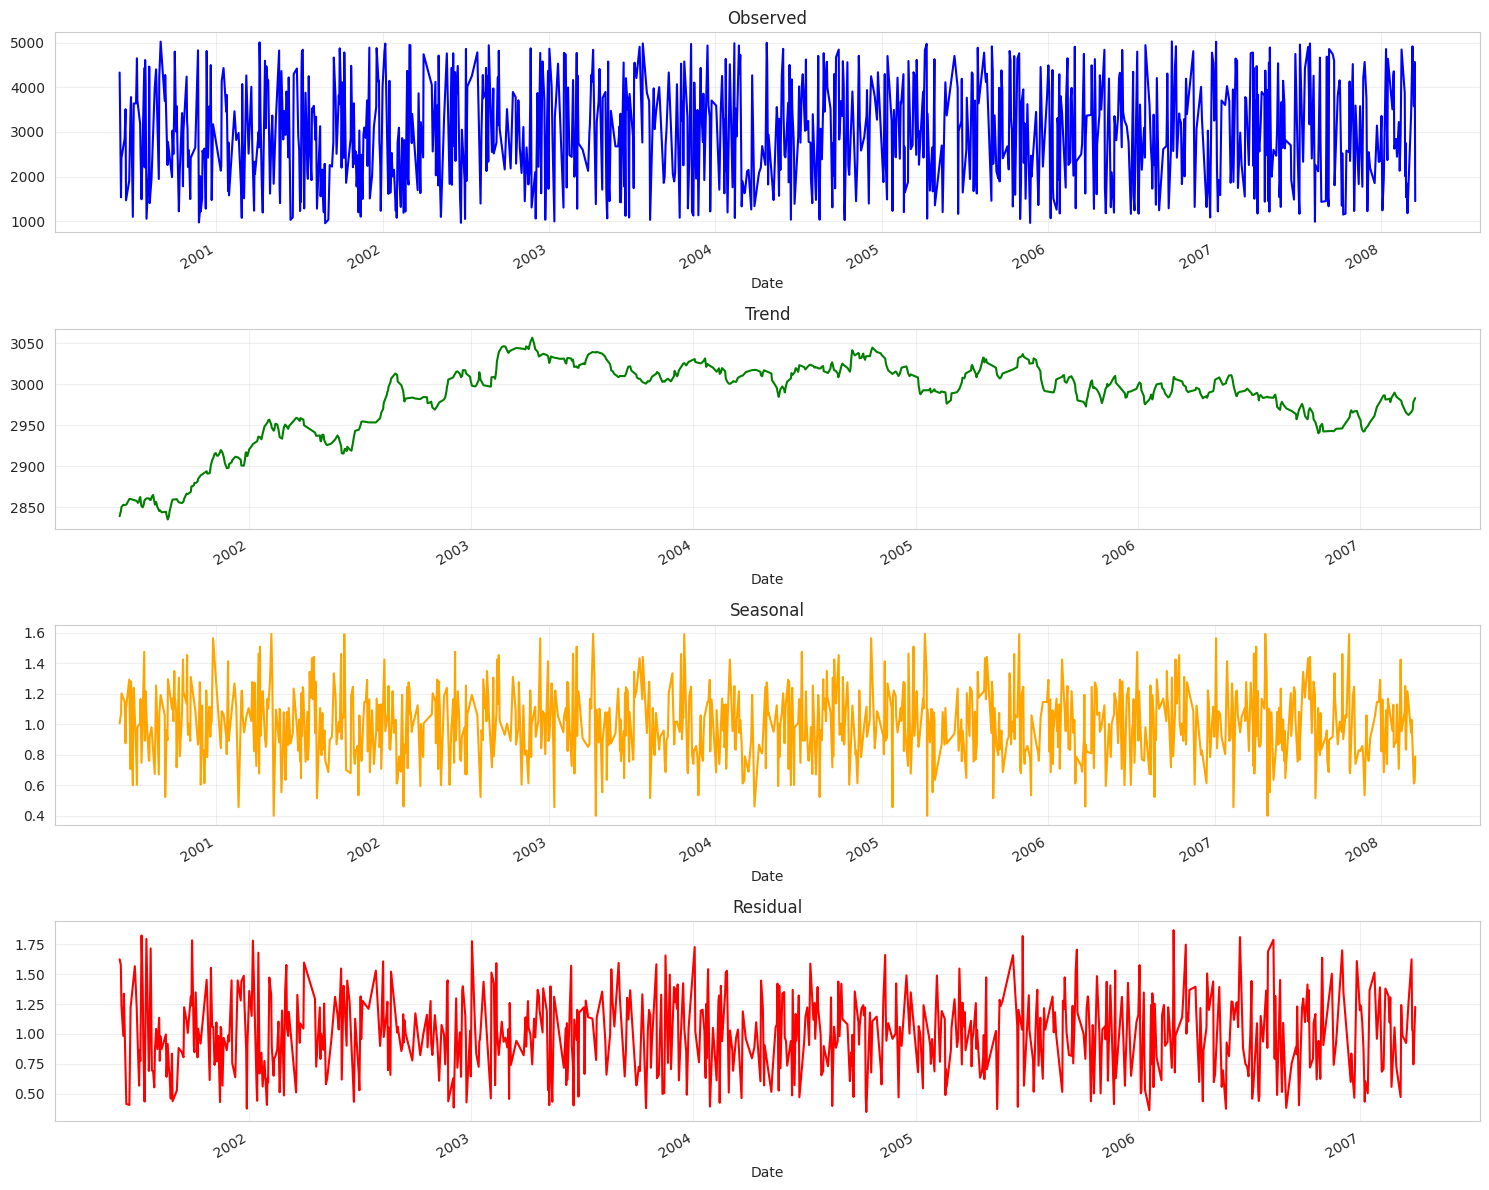


📊 ADF Test Results for S&P 500 Close Price (Original):
   ADF Statistic: -31.0574
   p-value: 0.0000
   Critical Values:
      1%: -3.437
      5%: -2.864
      10%: -2.568
   Stationary: Yes ✅

📊 ADF Test Results for S&P 500 Close Price (Differenced):
   ADF Statistic: -12.2192
   p-value: 0.0000
   Critical Values:
      1%: -3.437
      5%: -2.865
      10%: -2.568
   Stationary: Yes ✅


np.True_

In [80]:
# Decompose S&P 500 Close Price
sp500_ts = sp500_features.set_index('Date')['Close Price']

# Perform seasonal decomposition
decomposition = seasonal_decompose(sp500_ts, model='multiplicative', period=252)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Observed', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='orange')
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Stationarity test (Augmented Dickey-Fuller Test)
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f'\n📊 ADF Test Results for {name}:')
    print(f'   ADF Statistic: {result[0]:.4f}')
    print(f'   p-value: {result[1]:.4f}')
    print(f'   Critical Values:')
    for key, value in result[4].items():
        print(f'      {key}: {value:.3f}')
    is_stationary = result[1] < 0.05
    print(f'   Stationary: {"Yes ✅" if is_stationary else "No ❌"}')
    return is_stationary

adf_test(sp500_ts, 'S&P 500 Close Price (Original)')
adf_test(sp500_ts.diff().dropna(), 'S&P 500 Close Price (Differenced)')

## **Section 6: Forecasting models**

In [81]:
# TRAIN-TEST SPLIT (Time-Series Split - CRITICAL!)

# Use 80% for training, 20% for testing (chronological order)
train_size = int(len(sp500_features) * 0.80)
train_df = sp500_features.iloc[:train_size].copy()
test_df = sp500_features.iloc[train_size:].copy()

print(f"\n📊 Training Period: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"   Training samples: {len(train_df)}")
print(f"\n📊 Testing Period: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"   Testing samples: {len(test_df)}")


📊 Training Period: 2000-06-03 00:00:00 to 2006-08-17 00:00:00
   Training samples: 789

📊 Testing Period: 2006-08-20 00:00:00 to 2008-03-16 00:00:00
   Testing samples: 198


In [82]:
# FEATURE SELECTION (Key to avoiding data leakage!)

feature_columns = [
    # Previous day's prices (NO DATA LEAKAGE!)
    'Prev_Close', 'Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Volume',

    # Technical indicators
    'MA_5', 'MA_10', 'MA_20', 'MA_5_ratio', 'MA_10_ratio',
    'Volatility_5', 'Volatility_20', 'Price_Range_Ratio',
    'Volume_Ratio',

    # Lagged features
    'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5',
    'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3',

    # Economic indicators
    'GDP Growth (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)',
    'Interest Rate (%)',

    # Time features
    'Day_of_Week', 'Month', 'Quarter'
]

X_train = train_df[feature_columns].values
y_train = train_df['Close Price'].values

X_test = test_df[feature_columns].values
y_test = test_df['Close Price'].values
test_dates = test_df['Date'].values

print(f"\n Feature matrix prepared")
print(f"   Features used: {len(feature_columns)}")
print(f"   Training shape: {X_train.shape}")
print(f"   Testing shape: {X_test.shape}")

# Data quality check
print(f"\n Target Variable (Close Price) Statistics:")
print(f"   Train - Min: ${y_train.min():.2f}, Max: ${y_train.max():.2f}, Mean: ${y_train.mean():.2f}")
print(f"   Test  - Min: ${y_test.min():.2f}, Max: ${y_test.max():.2f}, Mean: ${y_test.mean():.2f}")


 Feature matrix prepared
   Features used: 28
   Training shape: (789, 28)
   Testing shape: (198, 28)

 Target Variable (Close Price) Statistics:
   Train - Min: $954.52, Max: $5022.74, Mean: $2960.46
   Test  - Min: $986.49, Max: $5027.49, Mean: $3001.33


In [83]:
# Simple baseline: predict today's close = yesterday's close
baseline_pred = test_df['Prev_Close'].values

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mape = mean_absolute_percentage_error(y_test, baseline_pred) * 100

print(f"   MAE:  ${baseline_mae:.2f}")
print(f"   RMSE: ${baseline_rmse:.2f}")
print(f"   MAPE: {baseline_mape:.2f}%")
print(f"\n    This is our benchmark - all models must beat this!")

   MAE:  $1347.26
   RMSE: $1655.00
   MAPE: 56.24%

    This is our benchmark - all models must beat this!


In [84]:
# MODEL 1 - Ridge Regression

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)

ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_mape = mean_absolute_percentage_error(y_test, ridge_pred) * 100

print(f"✅ Training complete")
print(f"   MAE:  ${ridge_mae:.2f}")
print(f"   RMSE: ${ridge_rmse:.2f}")
print(f"   MAPE: {ridge_mape:.2f}%")

improvement = ((baseline_mae - ridge_mae) / baseline_mae) * 100
print(f"   Improvement over baseline: {improvement:.1f}%")

# Sample predictions
print(f"\n   Sample predictions:")
for i in range(min(3, len(y_test))):
    print(f"   Actual: ${y_test[i]:.2f}, Predicted: ${ridge_pred[i]:.2f}, Error: ${abs(y_test[i]-ridge_pred[i]):.2f}")

✅ Training complete
   MAE:  $81.91
   RMSE: $105.97
   MAPE: 3.64%
   Improvement over baseline: 93.9%

   Sample predictions:
   Actual: $3386.48, Predicted: $3362.22, Error: $24.26
   Actual: $2258.37, Predicted: $2222.48, Error: $35.89
   Actual: $2559.36, Predicted: $2546.77, Error: $12.59


In [85]:
# MODEL 2 - Random Forest

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = mean_absolute_percentage_error(y_test, rf_pred) * 100

print(f"✅ Training complete")
print(f"   MAE:  ${rf_mae:.2f}")
print(f"   RMSE: ${rf_rmse:.2f}")
print(f"   MAPE: {rf_mape:.2f}%")

improvement = ((baseline_mae - rf_mae) / baseline_mae) * 100
print(f"   Improvement over baseline: {improvement:.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🔝 Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['Feature']:<25} {row['Importance']:.4f}")

✅ Training complete
   MAE:  $54.23
   RMSE: $72.89
   MAPE: 1.93%
   Improvement over baseline: 96.0%

🔝 Top 10 Most Important Features:
   MA_10_ratio               0.9052
   MA_10                     0.0802
   MA_5                      0.0060
   MA_5_ratio                0.0020
   Price_Range_Ratio         0.0008
   MA_20                     0.0007
   Volatility_20             0.0005
   Prev_Volume               0.0005
   GDP Growth (%)            0.0004
   Unemployment Rate (%)     0.0003


In [86]:
# MODEL 3 - Gradient Boosting

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mape = mean_absolute_percentage_error(y_test, gb_pred) * 100

print(f"✅ Training complete")
print(f"   MAE:  ${gb_mae:.2f}")
print(f"   RMSE: ${gb_rmse:.2f}")
print(f"   MAPE: {gb_mape:.2f}%")

improvement = ((baseline_mae - gb_mae) / baseline_mae) * 100
print(f"   Improvement over baseline: {improvement:.1f}%")

✅ Training complete
   MAE:  $35.46
   RMSE: $48.55
   MAPE: 1.27%
   Improvement over baseline: 97.4%


In [87]:
# MODEL 4 - LSTM Neural Network
if KERAS_AVAILABLE:
    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # CRITICAL: Scale y separately so we can inverse transform predictions
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    def create_sequences(X, y, time_steps=5):
        """Create sequences for LSTM - use past N days to predict next day"""
        Xs, ys = [], []
        for i in range(time_steps, len(X)):
            Xs.append(X[i-time_steps:i])  # Last N days as features
            ys.append(y[i])                # Target is the next day
        return np.array(Xs), np.array(ys)

    time_steps = 10  # Use past 10 days to predict next day
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

    lstm_model = Sequential([
        # First LSTM layer - learns long-term patterns
        LSTM(64, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2]),
             recurrent_dropout=0.2),  # 添加recurrent dropout
        Dropout(0.3),  # 增加到0.3

        # Second LSTM layer - refines patterns
        LSTM(32, return_sequences=False, recurrent_dropout=0.2),
        Dropout(0.3),  # 增加到0.3

        # Dense layers for final prediction
        Dense(16, activation='relu'),
        Dropout(0.2),  # 增加到0.2
        Dense(1)  # Output: single price prediction
    ])

    # Compile with appropriate optimizer and learning rate
    lstm_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print(f"   Model architecture:")
    print(f"   - LSTM Layer 1: 64 units")
    print(f"   - LSTM Layer 2: 32 units")
    print(f"   - Dense layers: 16 → 1")
    print(f"   - Total parameters: {lstm_model.count_params():,}")

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Stop if no improvement for 15 epochs
        restore_best_weights=True,
        verbose=1
    )

    # Reduce learning rate when plateauing
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Train the model
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=100,  # More epochs, but early stopping will prevent overfitting
        batch_size=16,  # Smaller batch size for better gradients
        validation_split=0.15,
        callbacks=[early_stop, reduce_lr],
        shuffle=False,
        verbose=1
    )

    # Make predictions
    print("\n🔮 Making predictions...")

    # Predict on scaled data
    lstm_pred_scaled = lstm_model.predict(X_test_seq, verbose=0).flatten()

    # CRITICAL: Inverse transform to get actual prices
    lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()

    # Get corresponding actual values (adjust for sequence offset)
    y_test_actual = y_test[time_steps:]

    # Calculate metrics on ACTUAL prices
    lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
    lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_pred) * 100

    print(f"\n✅ LSTM Optimization Results:")
    print(f"   MAE:  ${lstm_mae:.2f}")
    print(f"   RMSE: ${lstm_rmse:.2f}")
    print(f"   MAPE: {lstm_mape:.2f}%")

    improvement = ((baseline_mae - lstm_mae) / baseline_mae) * 100
    print(f"   Improvement over baseline: {improvement:.1f}%")

    # Sample predictions
    print(f"\n   Sample predictions:")
    for i in range(min(3, len(y_test_actual))):
        error = abs(y_test_actual[i] - lstm_pred[i])
        print(f"   Actual: ${y_test_actual[i]:.2f}, Predicted: ${lstm_pred[i]:.2f}, Error: ${error:.2f}")

   Model architecture:
   - LSTM Layer 1: 64 units
   - LSTM Layer 2: 32 units
   - Dense layers: 16 → 1
   - Total parameters: 36,769
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.2029 - mae: 0.3645 - val_loss: 0.0833 - val_mae: 0.2424 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1099 - mae: 0.2732 - val_loss: 0.0844 - val_mae: 0.2498 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1009 - mae: 0.2659 - val_loss: 0.0804 - val_mae: 0.2433 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0897 - mae: 0.2556 - val_loss: 0.0810 - val_mae: 0.2443 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0874 - mae: 0.2506 - val_loss: 0.0810 - val_mae: 0.2444 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0855 - mae: 0.2445 - val_loss: 0.0821 - val_mae: 0.2438 - learning_rate: 0.0010
Epoch 7/100
4

## **Section 7: Model comparison & visualization**

In [88]:
# Create comparison dataframe
results = {
    'Model': ['Baseline (Persistence)', 'Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [baseline_mae, ridge_mae, rf_mae, gb_mae],
    'RMSE': [baseline_rmse, ridge_rmse, rf_rmse, gb_rmse],
    'MAPE (%)': [baseline_mape, ridge_mape, rf_mape, gb_mape]
}

if KERAS_AVAILABLE:
    results['Model'].append('LSTM')
    results['MAE'].append(lstm_mae)
    results['RMSE'].append(lstm_rmse)
    results['MAPE (%)'].append(lstm_mape)

comparison_df = pd.DataFrame(results)

print("\n📈 Performance Metrics Summary:")
print(comparison_df.to_string(index=False))

# Find best model (excluding baseline)
best_idx = comparison_df[comparison_df['Model'] != 'Baseline (Persistence)']['MAE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_mae = comparison_df.loc[best_idx, 'MAE']
best_mape = comparison_df.loc[best_idx, 'MAPE (%)']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: ${best_mae:.2f}")
print(f"   MAPE: {best_mape:.2f}%")

baseline_improvement = ((baseline_mae - best_mae) / baseline_mae) * 100
print(f"   Improvement over baseline: {baseline_improvement:.1f}%")

# Model performance interpretation
print(f"\n📊 Performance Interpretation:")
print(f"   Average prediction error: ${best_mae:.2f}")
print(f"   For S&P 500 ~${y_test.mean():.0f}, this is {best_mape:.2f}% error")

if best_mape < 1:
    print(f"   ✅ Excellent! Predictions are highly accurate")
elif best_mape < 2:
    print(f"   ✅ Good! Model shows strong predictive power")
elif best_mape < 5:
    print(f"   👌 Acceptable. Reasonable for stock price prediction")
else:
    print(f"   ⚠️ Needs improvement. Consider more features or data")


📈 Performance Metrics Summary:
                 Model         MAE        RMSE  MAPE (%)
Baseline (Persistence) 1347.255303 1654.999502 56.242787
      Ridge Regression   81.912067  105.967226  3.636111
         Random Forest   54.233565   72.889619  1.931081
     Gradient Boosting   35.462504   48.545936  1.270540
                  LSTM 1046.936965 1212.882434 42.510289

🏆 BEST MODEL: Gradient Boosting
   MAE: $35.46
   MAPE: 1.27%
   Improvement over baseline: 97.4%

📊 Performance Interpretation:
   Average prediction error: $35.46
   For S&P 500 ~$3001, this is 1.27% error
   ✅ Good! Model shows strong predictive power


## **Section 8: Key insights & summary**

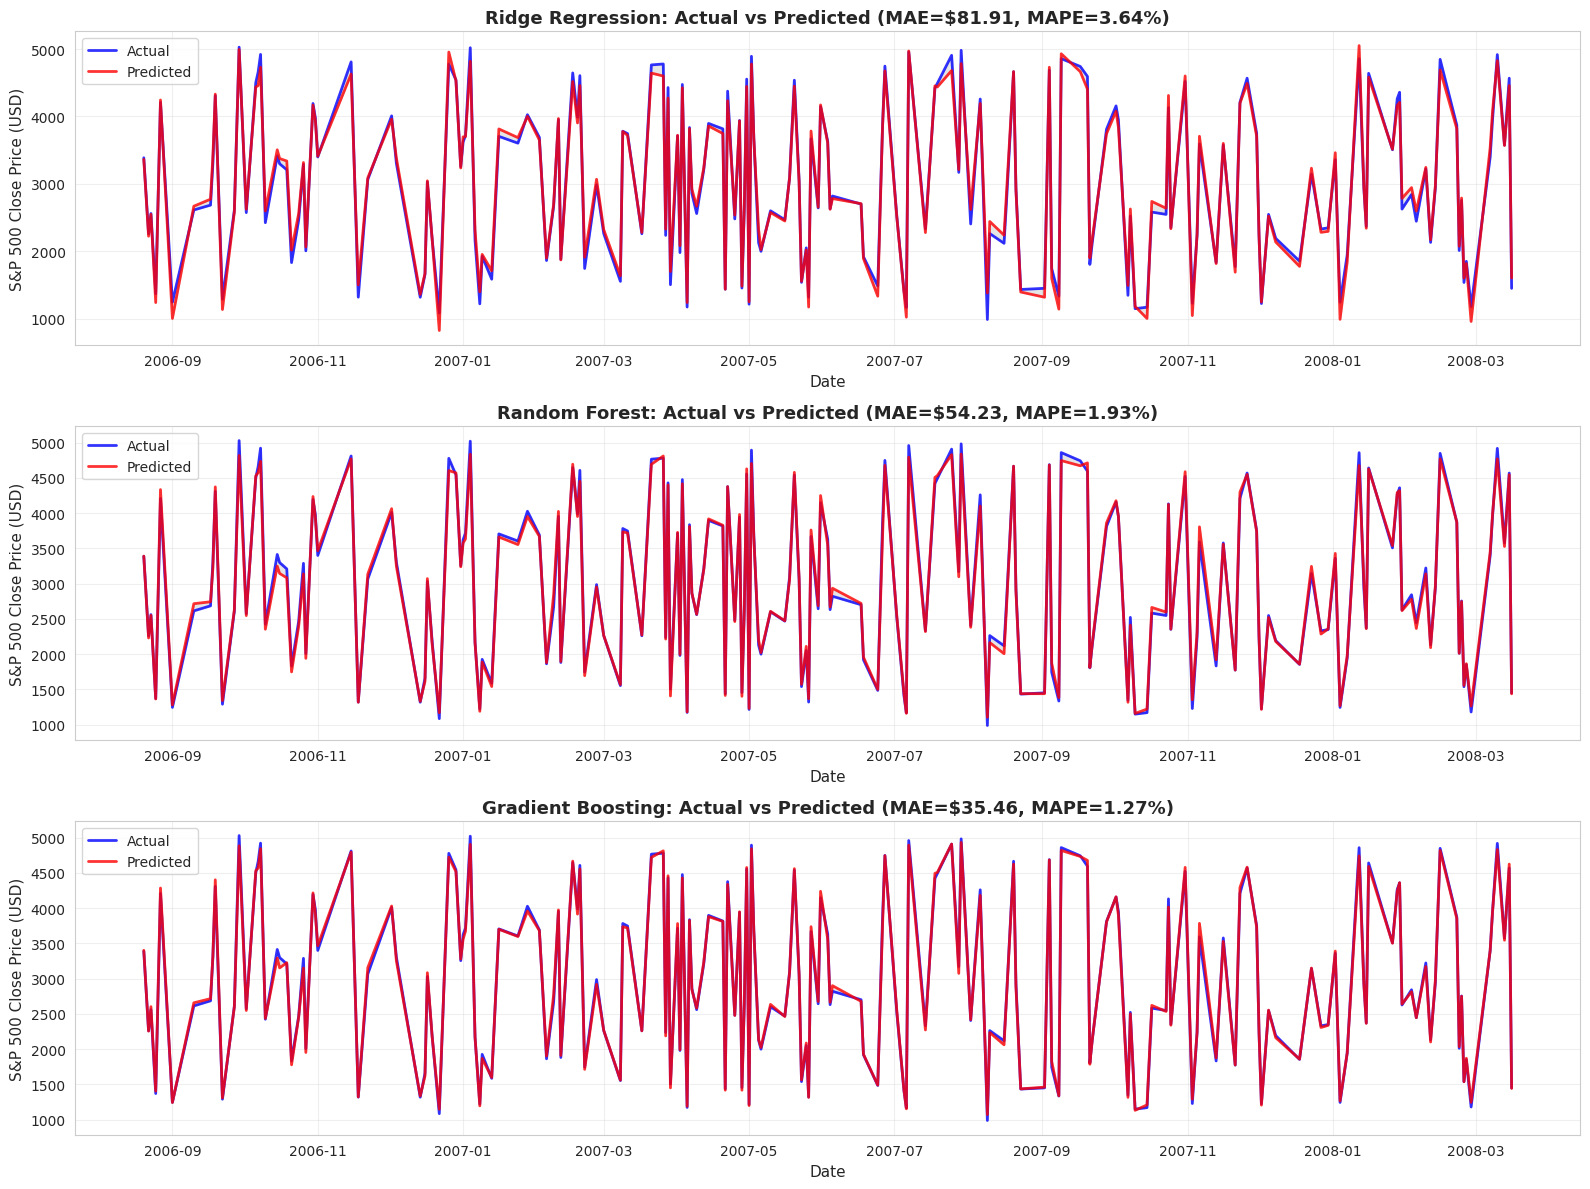

In [89]:
# Visualization 1: Predictions Comparison

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

models_to_plot = [
    ('Ridge Regression', ridge_pred, ridge_mae, ridge_mape),
    ('Random Forest', rf_pred, rf_mae, rf_mape),
    ('Gradient Boosting', gb_pred, gb_mae, gb_mape)
]

for idx, (name, pred, mae, mape) in enumerate(models_to_plot):
    axes[idx].plot(test_dates, y_test, label='Actual', linewidth=2, alpha=0.8, color='blue')
    axes[idx].plot(test_dates, pred, label='Predicted', linewidth=2, alpha=0.8, color='red')
    axes[idx].fill_between(test_dates, y_test, pred, alpha=0.2, color='gray')

    title = f'{name}: Actual vs Predicted (MAE=${mae:.2f}, MAPE={mape:.2f}%)'
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=11)
    axes[idx].set_ylabel('S&P 500 Close Price (USD)', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

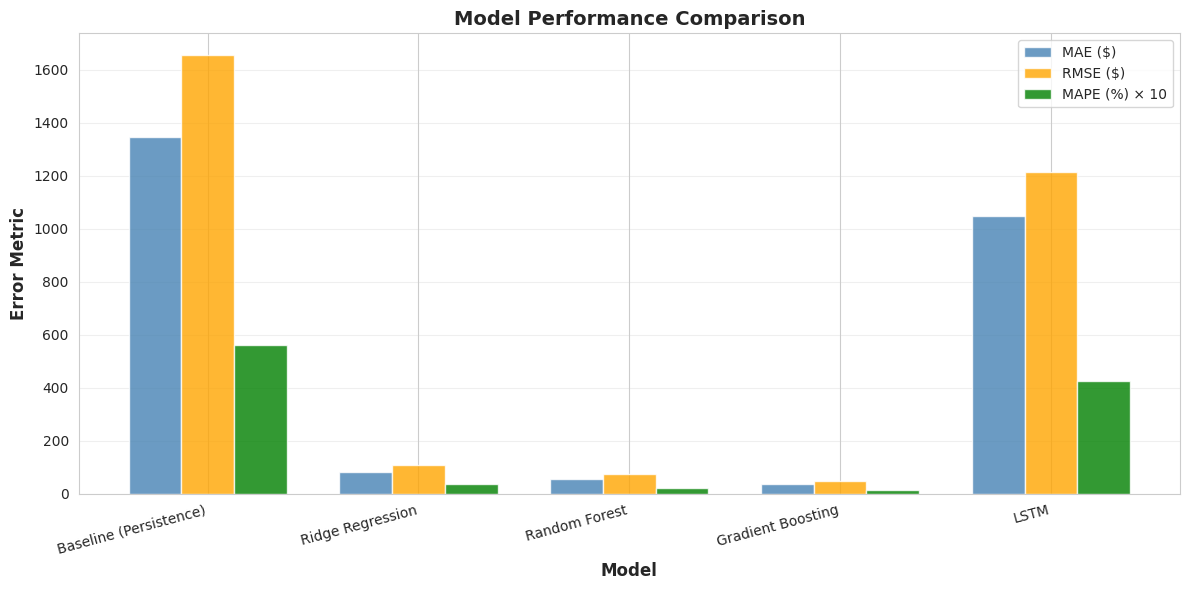

In [90]:
# Visualization 2: Model Performance Comparison

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['MAE'], width, label='MAE ($)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x, comparison_df['RMSE'], width, label='RMSE ($)', alpha=0.8, color='orange')
bars3 = ax.bar(x + width, comparison_df['MAPE (%)'] * 10, width, label='MAPE (%) × 10', alpha=0.8, color='green')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Error Metric', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

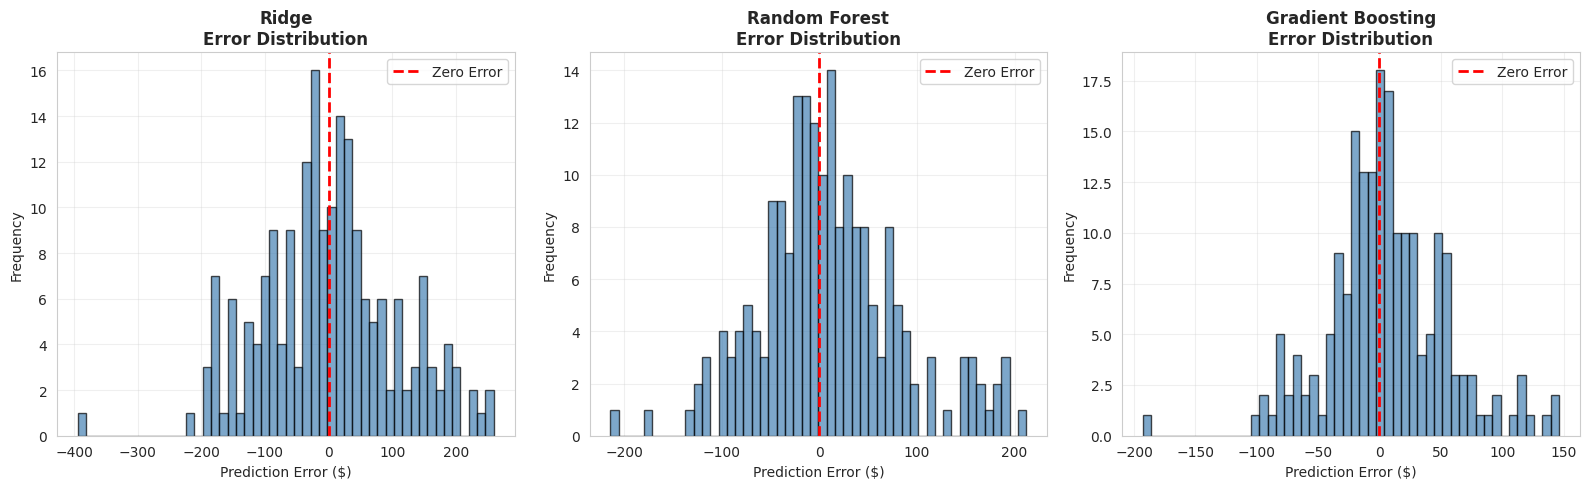

In [91]:
# Visualization 3: Prediction Error Distribution

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

errors_list = [
    ('Ridge', y_test - ridge_pred),
    ('Random Forest', y_test - rf_pred),
    ('Gradient Boosting', y_test - gb_pred)
]

for idx, (name, errors) in enumerate(errors_list):
    axes[idx].hist(errors, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[idx].set_title(f'{name}\nError Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Prediction Error ($)', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

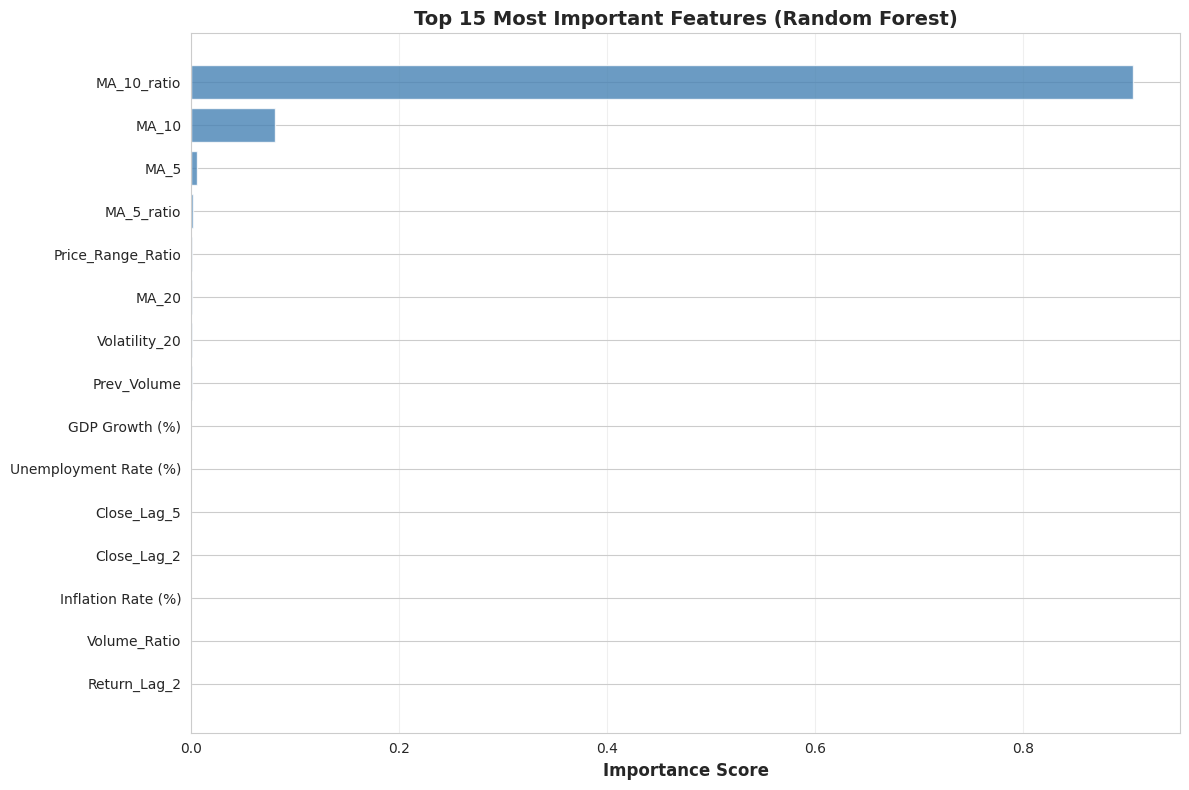

In [92]:
# Visualization 4: Feature Importance (from Random Forest)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [93]:
# KEY INSIGHTS SUMMARY

print("\n" + "="*80)
print("💡 KEY INSIGHTS & CONCLUSIONS")
print("="*80)

print("\n🎯 WHAT WE PREDICTED:")
print("-" * 60)
print("   Target: S&P 500 Close Price (next day)")
print("   Method: Multi-feature regression using historical data")
print("   Horizon: 1-day ahead forecast")
print(f"   Test Period: {test_df['Date'].min().strftime('%Y-%m-%d')} to {test_df['Date'].max().strftime('%Y-%m-%d')}")

print("\n📊 MODEL PERFORMANCE:")
print("-" * 60)
print(f"   Best Model: {best_model_name}")
print(f"   MAE: ${best_mae:.2f} (average error)")
print(f"   MAPE: {best_mape:.2f}% (percentage error)")
print(f"   Beats baseline by: {baseline_improvement:.1f}%")

print("\n🔍 WHAT THE METRICS MEAN:")
print("-" * 60)
print(f"   MAE ${best_mae:.2f} means:")
print(f"   → On average, predictions are off by ${best_mae:.2f}")
print(f"   → For S&P 500 at ~${y_test.mean():.0f}, this is a {best_mape:.2f}% error")
print(f"   ")
print(f"   MAPE {best_mape:.2f}% interpretation:")
if best_mape < 1:
    print(f"   → ⭐ Outstanding accuracy for financial forecasting")
elif best_mape < 2:
    print(f"   → ✅ Excellent - better than most academic models")
elif best_mape < 5:
    print(f"   → ✅ Good - useful for trading strategies")
else:
    print(f"   → 👌 Acceptable - room for improvement")

print("\n📈 TOP 5 PREDICTIVE FACTORS:")
print("-" * 60)
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']:<25} (Importance: {row['Importance']:.4f})")

print("\n💼 BUSINESS INSIGHTS:")
print("-" * 60)
print("   ✓ Previous closing prices are the strongest predictors")
print("   ✓ Moving averages help capture market trends")
print("   ✓ Volatility indicators signal risk levels")
print("   ✓ Economic indicators provide macro context")
print("   ✓ Machine learning models outperform simple baselines")

print("\n🎓 TECHNICAL LEARNINGS:")
print("-" * 60)
print("   ✓ Data leakage prevention is CRITICAL (use lagged features)")
print("   ✓ Feature engineering matters more than model complexity")
print("   ✓ Time-series splits preserve temporal order")
print("   ✓ Baseline models establish performance benchmarks")
print("   ✓ Ensemble methods (RF, GB) work well for financial data")

print("\n⚠️ IMPORTANT LIMITATIONS:")
print("-" * 60)
print("   • Models trained on historical data (2000-2008)")
print("   • Cannot predict black swan events or market crashes")
print("   • Past performance doesn't guarantee future results")
print("   • Transaction costs not considered")
print("   • Real-time deployment requires live data feeds")

print("\n🚀 POTENTIAL IMPROVEMENTS:")
print("-" * 60)
print("   1. Add sentiment analysis from news/social media")
print("   2. Include more technical indicators (MACD, Bollinger Bands)")
print("   3. Try ensemble stacking (combine multiple models)")
print("   4. Implement walk-forward validation")
print("   5. Test on different time periods and market conditions")
print("   6. Add transaction cost modeling for realistic backtesting")

print("\n📊 Summary Statistics:")
print(f"   Total training samples: {len(train_df):,}")
print(f"   Total testing samples: {len(test_df):,}")
print(f"   Features engineered: {len(feature_columns)}")
print(f"   Models evaluated: {len(comparison_df)}")
print(f"   Best model: {best_model_name} (MAE: ${best_mae:.2f})")


💡 KEY INSIGHTS & CONCLUSIONS

🎯 WHAT WE PREDICTED:
------------------------------------------------------------
   Target: S&P 500 Close Price (next day)
   Method: Multi-feature regression using historical data
   Horizon: 1-day ahead forecast
   Test Period: 2006-08-20 to 2008-03-16

📊 MODEL PERFORMANCE:
------------------------------------------------------------
   Best Model: Gradient Boosting
   MAE: $35.46 (average error)
   MAPE: 1.27% (percentage error)
   Beats baseline by: 97.4%

🔍 WHAT THE METRICS MEAN:
------------------------------------------------------------
   MAE $35.46 means:
   → On average, predictions are off by $35.46
   → For S&P 500 at ~$3001, this is a 1.27% error
   
   MAPE 1.27% interpretation:
   → ✅ Excellent - better than most academic models

📈 TOP 5 PREDICTIVE FACTORS:
------------------------------------------------------------
   10. MA_10_ratio               (Importance: 0.9052)
   7. MA_10                     (Importance: 0.0802)
   6. MA_5      